In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rotate
from multiprocess import Pool

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *
from cell_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node
rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


No vtk
Child returned 0
Child returned 1
0.38 seconds.
File does not exist: /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt
Child returned 0


rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


In [2]:
def align_pad_cells(stack, sec, common_shape):
    """
    Rotate cells so that its major axis is horizontal, AND centroid is at the upper-right quadrant of bbox.
    Output as bp file.
    """

    sys.stderr.write('Processing section: %03d\n' % sec)

    try:
        blob_orientations = load_cell_data('orientation', stack, sec)
        blob_masks = load_cell_data('mask', stack, sec)
        blob_mask_centers = load_cell_data('mask_center', stack, sec)
    except:
        sys.stderr.write('ERROR: %d\n' % sec)
        return

    n_blobs = len(blob_masks)

    t = time.time()

    # Align major axis
    cells_aligned = [rotate(blob_masks[i], angle=-np.rad2deg(blob_orientations[i]),
                               center=blob_mask_centers[i],
                               cval=0.) > .5
                    for i in range(n_blobs)]
    
    # Mirror
    # Put mask centroid in the upper-right quadrant of bbox.
    
    cells_aligned_mirrored = []
    mirror_directions = []
    
    for i in range(n_blobs):
        m = cells_aligned[i]
        bbox_cx = m.shape[1]/2
        bbox_cy = m.shape[0]/2
        mask_cx, mask_cy = blob_mask_centers[i]
#         m[mask_cy, mask_cx] = 0
#         m[bbox_cy-1:bbox_cy+2, bbox_cx-1:bbox_cx+2] = 0
        if mask_cx > bbox_cx:
            if mask_cy > bbox_cy:
                cells_aligned_mirrored.append(m[::-1, :])
                mirror = 1 # vertical flip
            else:
                cells_aligned_mirrored.append(m)
                mirror = 0
        else:
            if mask_cy > bbox_cy:
                cells_aligned_mirrored.append(m[::-1, ::-1])
                mirror = 3 # diagonal flip
            else:
                cells_aligned_mirrored.append(m[:, ::-1])
                mirror = 2 # horizontal flip
        mirror_directions.append(mirror)
    
    sys.stderr.write('Rotate cell masks: %.2f seconds.\n' % (time.time() - t)) # 60s

    cells_padded = pad_patches_to_same_size(cells_aligned_mirrored, pad_value=0, keep_center=True, common_shape=common_shape)
    cells_padded_fp = get_cell_data_filepath('cells_aligned_mirrored_padded', stack, sec=sec, ext='bp')
    bp.pack_ndarray_file(np.asarray(cells_padded), cells_padded_fp)
    upload_to_s3(cells_padded_fp)
    
    cells_mirror_direction_fp = get_cell_data_filepath('cells_aligned_mirrorDirections', stack, sec=sec, ext='bp')
    bp.pack_ndarray_file(np.asarray(mirror_directions), cells_mirror_direction_fp)
    upload_to_s3(cells_mirror_direction_fp)    
    
    #     return cells_padded

In [4]:
# all_shapes = []
# for sec in range(first_bs_section, last_bs_section+1):
#     masks = load_cell_data('mask', stack=stack, sec=sec)
#     if masks is not None:
#         shapes = [m.shape for m in masks.tolist()]
#         all_shapes += shapes

# common_shape = np.percentile(all_shapes, 99, axis=0).astype(np.int)
# print common_shape

common_shape = (57,62)

In [ ]:
# for stack in all_nissl_stacks:
for stack in ['MD585']:
# for stack in ['MD595',
#  'MD598',
#  'MD599',
#  'MD602',
#  'MD603']:
    
    sys.stderr.write('\nStack %s\n' % stack)
    
    first_bs_section, last_bs_section = metadata_cache['section_limits'][stack]
    
    t = time.time()

    pool = Pool(12)
    pool.map(lambda sec: align_pad_cells(stack, sec, common_shape=common_shape), 
             range(first_bs_section, last_bs_section+1))
    pool.close()
    pool.join()

    sys.stderr.write('Align cells overall: %.2f\n' % (time.time() - t)) # 330 seconds / stack


Stack MD585
Processing section: 083
Processing section: 101
Processing section: 095
Processing section: 107
Processing section: 125
Processing section: 137
Processing section: 131
Processing section: 143
Processing section: 113
Processing section: 119
Processing section: 089
Processing section: 149


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075/MD585-N25-2015.08.19-15.33.31_MD585_3_0075_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075/MD585-N25-2015.08.19-15.33.31_MD585_3_0075_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075/MD585-N25-2015.08.19-15.33.31_MD585_3_0075_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057/MD585-N19-2015.07.16-20.43.18_MD585_3_0057_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057/MD585-N19-2015.07.16-20.43.18_MD585_3_0057_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057/MD585-N19-2015.07.16-20.43.18_MD585_3_0057_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051/MD585-N17-2015.07.16-20.35.23_MD585_3_0051_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051/MD585-N17-2015.07.16-20.35.23_MD585_3_0051_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051/MD585-N17-2015.07.16-20.35.23_MD585_3_0051_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063/MD585-N21-2015.07.18-07.06.33_MD585_3_0063_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054/MD585-N18-2015.07.16-20.39.16_MD585_3_0054_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_3_0069/MD585-N23-2015.07.16-20.51.24_MD585_3_0069_blobMaskCenters.bp && mkdir -p /sh

Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063/MD585-N21-2015.07.18-07.06.33_MD585_3_0063_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063/MD585-N21-2015.07.18-07.06.33_MD585_3_0063_blobMaskCenters.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054/MD585-N18-2015.07.16-20.39.16_MD585_3_0054_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054/MD585-N18-2015.07.16-20.39.16_MD585_3_0054_blobMaskCenters.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_3_0069/MD585-N23-2015.07.16-20.51.24_MD585_3_0069_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_3_0069/MD585-N23-2015.07.16-20.51.24_MD585_3_0069_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072/MD585-N24-2015.08.19-15.29.12_MD585_3_0072_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072/MD585-N24-2015.08.19-15.29.12_MD585_3_0072_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072/MD585-N24-2015.08.19-15.29.12_MD585_3_0072_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066/MD585-N22-2015.07.18-07.10.40_MD585_3_0066_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060/MD585-N20-2015.07.16-20.47.19_MD585_3_0060_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066/MD585-N22-2015.07.18-07.10.40_MD585_3_0066_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066/MD585-N22-2015.07.18-07.10.40_MD585_3_0066_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060/MD585-N20-2015.07.16-20.47.19_MD585_3_0060_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060/MD585-N20-2015.07.16-20.47.19_MD585_3_0060_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078/MD585-N26-2015.08.19-15.37.53_MD585_3_0078_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078


Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081/MD585-N27-2015.08.19-15.42.30_MD585_3_0081_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_blobMaskCenters.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078/MD585-N26-2015.08.19-15.37.53_MD585_3_0078_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078/MD585-N26-2015.08.19-15.37.53_MD585_3_0078_blobMaskCenters.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081/MD585-N27-2015.08.19-15.42.30_MD585_3_0081_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081/MD585-N27-2015.08.19-15.42.30_MD585_3_0081_blobMaskCenters.bp


Child returned 0
0.73 seconds.
Child returned 0
0.65 seconds.
Child returned 0
0.65 seconds.
Child returned 0
0.78 seconds.
Child returned 0
0.65 seconds.
Child returned 0
0.74 seconds.
Child returned 0
0.64 seconds.
Child returned 0
0.62 seconds.
Child returned 0
0.63 seconds.
Child returned 0
0.78 seconds.
Child returned 0
Child returned 0
0.68 seconds.
0.75 seconds.
Rotate cell masks: 7.91 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054/MD585-N18-2015.07.16-20.39.16_MD585_3_0054_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054/MD585-N18-2015.07.16-20.39.16_MD585_3_0054_cells_aligned_mirrored_padded.bp


Child returned 0
0.80 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054/MD585-N18-2015.07.16-20.39.16_MD585_3_0054_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_3_0054/MD585-N18-2015.07.16-20.39.16_MD585_3_0054_cells_aligned_mirrorDirections.bp


Rotate cell masks: 10.08 seconds.
Rotate cell masks: 10.33 seconds.
Child returned 0
0.68 seconds.
Rotate cell masks: 10.59 seconds.
Rotate cell masks: 10.51 seconds.
Processing section: 096
Rotate cell masks: 10.60 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_blobMaskCenters.bp


Rotate cell masks: 11.02 seconds.
Rotate cell masks: 11.23 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_cells_aligned_mirrored_padded.bp


Rotate cell masks: 11.11 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051/MD585-N17-2015.07.16-20.35.23_MD585_3_0051_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051/MD585-N17-2015.07.16-20.35.23_MD585_3_0051_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060/MD585-N20-2015.07.16-20.47.19_MD585_3_0060_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060/MD585-N20-2015.07.16-20.47.19_MD585_3_0060_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078/MD585-N26-2015.08.19-15.37.53_MD585_3_0078_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078/MD585-N26-2015.08.19

Child returned 0
0.87 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057/MD585-N19-2015.07.16-20.43.18_MD585_3_0057_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057/MD585-N19-2015.07.16-20.43.18_MD585_3_0057_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075/MD585-N25-2015.08.19-15.33.31_MD585_3_0075_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075/MD585-N25-2015.08.19-15.33.31_MD585_3_0075_cells_aligned_mirrored_padded.bp


Child returned 0
0.73 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072/MD585-N24-2015.08.19-15.29.12_MD585_3_0072_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072/MD585-N24-2015.08.19-15.29.12_MD585_3_0072_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N16-2015.07.16-20.32.33_MD585_2_0047/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_cells_aligned_mirrorDirections.bp


Rotate cell masks: 11.90 seconds.
Rotate cell masks: 12.12 seconds.
Rotate cell masks: 12.08 seconds.
Child returned 0
0.72 seconds.
Child returned 0


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060/MD585-N20-2015.07.16-20.47.19_MD585_3_0060_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_3_0060/MD585-N20-2015.07.16-20.47.19_MD585_3_0060_cells_aligned_mirrorDirections.bp


0.87 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051/MD585-N17-2015.07.16-20.35.23_MD585_3_0051_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_3_0051/MD585-N17-2015.07.16-20.35.23_MD585_3_0051_cells_aligned_mirrorDirections.bp


Child returned 0
0.74 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078/MD585-N26-2015.08.19-15.37.53_MD585_3_0078_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_3_0078/MD585-N26-2015.08.19-15.37.53_MD585_3_0078_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081/MD585-N27-2015.08.19-15.42.30_MD585_3_0081_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081/MD585-N27-2015.08.19-15.42.30_MD585_3_0081_cells_aligned_mirrored_padded.bp


Child returned 0
0.69 seconds.
Child returned 0
0.92 seconds.
Child returned 0


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066/MD585-N22-2015.07.18-07.10.40_MD585_3_0066_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066/MD585-N22-2015.07.18-07.10.40_MD585_3_0066_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075/MD585-N25-2015.08.19-15.33.31_MD585_3_0075_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_3_0075/MD585-N25-2015.08.19-15.33.31_MD585_3_0075_cells_aligned_mirrorDirections.bp


0.84 seconds.
Processing section: 084


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072/MD585-N24-2015.08.19-15.29.12_MD585_3_0072_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_3_0072/MD585-N24-2015.08.19-15.29.12_MD585_3_0072_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_3_0069/MD585-N23-2015.07.16-20.51.24_MD585_3_0069_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_3_0069/MD585-N23-2015.07.16-20.51.24_MD585_3_0069_cells_aligned_mirrored_padded.bp


Child returned 0
1.00 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057/MD585-N19-2015.07.16-20.43.18_MD585_3_0057_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_3_0057/MD585-N19-2015.07.16-20.43.18_MD585_3_0057_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_blobMaskCenters.bp


Child returned 0
0.68 seconds.
Child returned 0
0.68 seconds.
Child returned 0
0.69 seconds.
Processing section: 090
Processing section: 108
Processing section: 144


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051


Child returned 0
0.74 seconds.
Child returned 0


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081/MD585-N27-2015.08.19-15.42.30_MD585_3_0081_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_3_0081/MD585-N27-2015.08.19-15.42.30_MD585_3_0081_cells_aligned_mirrorDirections.bp
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_blobMaskCenters.bp


Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060


0.55 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078_blobMaskCenters.bp


Child returned 0
0.67 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066/MD585-N22-2015.07.18-07.10.40_MD585_3_0066_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_3_0066/MD585-N22-2015.07.18-07.10.40_MD585_3_0066_cells_aligned_mirrorDirections.bp


Child returned 0
0.62 seconds.
Processing section: 132
Child returned 0
0.68 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_3_0069/MD585-N23-2015.07.16-20.51.24_MD585_3_0069_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_3_0069/MD585-N23-2015.07.16-20.51.24_MD585_3_0069_cells_aligned_mirrorDirections.bp


Processing section: 102
Child returned 0
0.87 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072


0.71 seconds.
Child returned 0
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072_blobMaskCenters.bp


Processing section: 138


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057_blobMaskCenters.bp


Child returned 0
0.58 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075


Child returned 0
0.68 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075_blobMaskCenters.bp


Child returned 0
0.68 seconds.
Child returned 0
0.59 seconds.
Processing section: 150
Child returned 0
0.68 seconds.
Child returned 0
0.65 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081


Processing section: 120
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081_blobMaskCenters.bp


Processing section: 126
Child returned 0
0.71 seconds.
Child returned 0
0.62 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069_blobMaskCenters.bp


Child returned 0
0.68 seconds.
Child returned 0
0.62 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063/MD585-N21-2015.07.18-07.06.33_MD585_3_0063_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063/MD585-N21-2015.07.18-07.06.33_MD585_3_0063_cells_aligned_mirrored_padded.bp


Child returned 0
0.79 seconds.
Child returned 0
0.82 seconds.
Child returned 0
0.81 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063/MD585-N21-2015.07.18-07.06.33_MD585_3_0063_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_3_0063/MD585-N21-2015.07.18-07.06.33_MD585_3_0063_cells_aligned_mirrorDirections.bp


Child returned 0
0.66 seconds.
Processing section: 114


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063_blobMaskCenters.bp


Child returned 0
0.81 seconds.
Rotate cell masks: 8.92 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_cells_aligned_mirrored_padded.bp


Rotate cell masks: 8.56 seconds.
Child returned 0
0.85 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054/MD585-IHC18-2015.07.16-15.35.58_MD585_3_0054_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_cells_aligned_mirrored_padded.bp


Child returned 0
0.74 seconds.
Rotate cell masks: 9.02 seconds.
Processing section: 097


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055/MD585-N19-2015.07.16-20.43.18_MD585_1_0055_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055/MD585-N19-2015.07.16-20.43.18_MD585_1_0055_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055/MD585-N19-2015.07.16-20.43.18_MD585_1_0055_blobMaskCenters.bp


Child returned 0
0.76 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048/MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048_cells_aligned_mirrorDirections.bp


Rotate cell masks: 9.68 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060_cells_aligned_mirrored_padded.bp


Child returned 0
0.69 seconds.
Child returned 0
0.53 seconds.
Processing section: 085
Rotate cell masks: 9.88 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_cells_aligned_mirrored_padded.bp


Child returned 0
0.72 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060/MD585-IHC20-2015.07.16-15.43.53_MD585_3_0060_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049/MD585-N17-2015.07.16-20.35.23_MD585_1_0049_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049/MD585-N17-2015.07.16-20.35.23_MD585_1_0049_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049/MD585-N17-2015.07.16-20.35.23_MD585_1_0049_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057_cells_aligned_mirrored_padded.bp


Rotate cell masks: 10.67 seconds.
Child returned 0
0.75 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051/MD585-IHC17-2015.07.16-15.32.03_MD585_3_0051_cells_aligned_mirrorDirections.bp


Child returned 0
0.68 seconds.
Processing section: 109
Child returned 0
0.76 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061/MD585-N21-2015.07.18-07.06.33_MD585_1_0061_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061/MD585-N21-2015.07.18-07.06.33_MD585_1_0061_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061/MD585-N21-2015.07.18-07.06.33_MD585_1_0061_blobMaskCenters.bp


Child returned 0
0.71 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057/MD585-IHC19-2015.07.16-15.39.52_MD585_3_0057_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072_cells_aligned_mirrored_padded.bp


Rotate cell masks: 10.44 seconds.
Child returned 0
0.73 seconds.
Processing section: 091
Child returned 0
0.63 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052/MD585-N18-2015.07.16-20.39.16_MD585_1_0052_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052/MD585-N18-2015.07.16-20.39.16_MD585_1_0052_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052/MD585-N18-2015.07.16-20.39.16_MD585_1_0052_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066_cells_aligned_mirrored_padded.bp


Child returned 0
0.70 seconds.
Processing section: 103
Child returned 0
0.75 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072/MD585-IHC24-2015.07.18-07.14.51_MD585_3_0072_cells_aligned_mirrorDirections.bp


Rotate cell masks: 11.11 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058/MD585-N20-2015.07.16-20.47.19_MD585_1_0058_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058/MD585-N20-2015.07.16-20.47.19_MD585_1_0058_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058/MD585-N20-2015.07.16-20.47.19_MD585_1_0058_blobMaskCenters.bp


Rotate cell masks: 12.74 seconds.
Child returned 0
Child returned 0
0.74 seconds.
0.73 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066/MD585-IHC22-2015.07.16-15.51.54_MD585_3_0066_cells_aligned_mirrorDirections.bp


Child returned 0
0.68 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069_cells_aligned_mirrored_padded.bp


Processing section: 133
Child returned 0
0.69 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073/MD585-N25-2015.08.19-15.33.31_MD585_1_0073_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073


Rotate cell masks: 12.76 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073/MD585-N25-2015.08.19-15.33.31_MD585_1_0073_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073/MD585-N25-2015.08.19-15.33.31_MD585_1_0073_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078_cells_aligned_mirrored_padded.bp


Child returned 0
0.61 seconds.
Processing section: 121
Rotate cell masks: 13.10 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067/MD585-N23-2015.07.16-20.51.24_MD585_1_0067_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067/MD585-N23-2015.07.16-20.51.24_MD585_1_0067_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067/MD585-N23-2015.07.16-20.51.24_MD585_1_0067_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075_cells_aligned_mirrored_padded.bp


Child returned 0
0.91 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069/MD585-IHC23-2015.08.19-13.18.49_MD585_3_0069_cells_aligned_mirrorDirections.bp


Child returned 0
0.80 seconds.
Child returned 0
0.85 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078/MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081_cells_aligned_mirrored_padded.bp


Child returned 0
0.59 seconds.
Child returned 0
0.78 seconds.
Rotate cell masks: 11.11 seconds.
Processing section: 127
Child returned 0
0.86 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075/MD585-IHC25-2015.07.18-07.19.12_MD585_3_0075_cells_aligned_mirrorDirections.bp


Child returned 0
0.70 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_1_0070/MD585-N24-2015.08.19-15.29.12_MD585_1_0070_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_1_0070


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_1_0070/MD585-N24-2015.08.19-15.29.12_MD585_1_0070_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_1_0070/MD585-N24-2015.08.19-15.29.12_MD585_1_0070_blobMaskCenters.bp


Processing section: 145


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063_cells_aligned_mirrored_padded.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079/MD585-N27-2015.08.19-15.42.30_MD585_1_0079_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079/MD585-N27-2015.08.19-15.42.30_MD585_1_0079_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079/MD585-N27-2015.08.19-15.42.30_MD585_1_0079_blobMaskCenters.bp


Child returned 0
1.02 seconds.
Child returned 0
0.69 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081/MD585-IHC27-2015.08.19-13.28.05_MD585_3_0081_cells_aligned_mirrorDirections.bp


Child returned 0
Processing section: 139
0.72 seconds.
Child returned 0
0.61 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063/MD585-IHC21-2015.07.16-15.47.52_MD585_3_0063_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076/MD585-N26-2015.08.19-15.37.53_MD585_1_0076_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076


Child returned 0
0.52 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076/MD585-N26-2015.08.19-15.37.53_MD585_1_0076_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076/MD585-N26-2015.08.19-15.37.53_MD585_1_0076_blobMaskCenters.bp


Child returned 0
0.74 seconds.
Processing section: 151
Child returned 0
0.56 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082/MD585-N28-2015.08.19-15.47.09_MD585_1_0082_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082/MD585-N28-2015.08.19-15.47.09_MD585_1_0082_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082/MD585-N28-2015.08.19-15.47.09_MD585_1_0082_blobMaskCenters.bp


Processing section: 115
Child returned 0
0.80 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064/MD585-N22-2015.07.18-07.10.40_MD585_1_0064_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064/MD585-N22-2015.07.18-07.10.40_MD585_1_0064_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064/MD585-N22-2015.07.18-07.10.40_MD585_1_0064_blobMaskCenters.bp


Child returned 0
0.80 seconds.
Child returned 0
0.85 seconds.
Rotate cell masks: 10.69 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055/MD585-N19-2015.07.16-20.43.18_MD585_1_0055_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055/MD585-N19-2015.07.16-20.43.18_MD585_1_0055_cells_aligned_mirrored_padded.bp


Rotate cell masks: 8.49 seconds.
Rotate cell masks: 10.36 seconds.
Child returned 0
0.74 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055/MD585-N19-2015.07.16-20.43.18_MD585_1_0055_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_1_0055/MD585-N19-2015.07.16-20.43.18_MD585_1_0055_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052/MD585-N18-2015.07.16-20.39.16_MD585_1_0052_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052/MD585-N18-2015.07.16-20.39.16_MD585_1_0052_cells_aligned_mirrored_padded.bp


Rotate cell masks: 10.01 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049/MD585-N17-2015.07.16-20.35.23_MD585_1_0049_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049/MD585-N17-2015.07.16-20.35.23_MD585_1_0049_cells_aligned_mirrored_padded.bp


Child returned 0
0.56 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061/MD585-N21-2015.07.18-07.06.33_MD585_1_0061_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061/MD585-N21-2015.07.18-07.06.33_MD585_1_0061_cells_aligned_mirrored_padded.bp


Processing section: 098


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_blobMaskCenters.bp


Child returned 0
0.98 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052/MD585-N18-2015.07.16-20.39.16_MD585_1_0052_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_1_0052/MD585-N18-2015.07.16-20.39.16_MD585_1_0052_cells_aligned_mirrorDirections.bp


Rotate cell masks: 9.70 seconds.
Child returned 0
0.79 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049/MD585-N17-2015.07.16-20.35.23_MD585_1_0049_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_1_0049/MD585-N17-2015.07.16-20.35.23_MD585_1_0049_cells_aligned_mirrorDirections.bp


Child returned 0
0.76 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061/MD585-N21-2015.07.18-07.06.33_MD585_1_0061_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_1_0061/MD585-N21-2015.07.18-07.06.33_MD585_1_0061_cells_aligned_mirrorDirections.bp


Child returned 0
0.52 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058/MD585-N20-2015.07.16-20.47.19_MD585_1_0058_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058/MD585-N20-2015.07.16-20.47.19_MD585_1_0058_cells_aligned_mirrored_padded.bp


Processing section: 092
Child returned 0
0.84 seconds.
Child returned 0
0.69 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_blobMaskCenters.bp


Rotate cell masks: 9.72 seconds.
Processing section: 086


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_blobMaskCenters.bp


Child returned 0
0.76 seconds.
Child returned 0
0.68 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058/MD585-N20-2015.07.16-20.47.19_MD585_1_0058_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_1_0058/MD585-N20-2015.07.16-20.47.19_MD585_1_0058_cells_aligned_mirrorDirections.bp


Processing section: 110


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073/MD585-N25-2015.08.19-15.33.31_MD585_1_0073_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073/MD585-N25-2015.08.19-15.33.31_MD585_1_0073_cells_aligned_mirrored_padded.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061_blobMaskCenters.bp


Child returned 0
0.83 seconds.
Child returned 0
0.67 seconds.
Child returned 0
0.71 seconds.
Processing section: 104
Child returned 0
0.82 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073/MD585-N25-2015.08.19-15.33.31_MD585_1_0073_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_1_0073/MD585-N25-2015.08.19-15.33.31_MD585_1_0073_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058


Child returned 0
0.77 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058_blobMaskCenters.bp


Child returned 0
0.69 seconds.
Processing section: 134
Child returned 0
0.82 seconds.
Rotate cell masks: 11.57 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067/MD585-N23-2015.07.16-20.51.24_MD585_1_0067_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067/MD585-N23-2015.07.16-20.51.24_MD585_1_0067_cells_aligned_mirrored_padded.bp


Child returned 0
0.78 seconds.
Child returned 0
0.81 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067/MD585-N23-2015.07.16-20.51.24_MD585_1_0067_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_1_0067/MD585-N23-2015.07.16-20.51.24_MD585_1_0067_cells_aligned_mirrorDirections.bp


Child returned 0
0.68 seconds.
Rotate cell masks: 12.19 seconds.
Rotate cell masks: 12.76 seconds.
Processing section: 122
Rotate cell masks: 10.90 seconds.
Rotate cell masks: 11.91 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079/MD585-N27-2015.08.19-15.42.30_MD585_1_0079_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079/MD585-N27-2015.08.19-15.42.30_MD585_1_0079_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064/MD585-N22-2015.07.18-07.10.40_MD585_1_0064_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064/MD585-N22-2015.07.18-07.10.40_MD585_1_00

Child returned 0
0.73 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076/MD585-N26-2015.08.19-15.37.53_MD585_1_0076_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076/MD585-N26-2015.08.19-15.37.53_MD585_1_0076_cells_aligned_mirrored_padded.bp


Child returned 0
0.73 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079/MD585-N27-2015.08.19-15.42.30_MD585_1_0079_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_1_0079/MD585-N27-2015.08.19-15.42.30_MD585_1_0079_cells_aligned_mirrorDirections.bp


Child returned 0
0.79 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064/MD585-N22-2015.07.18-07.10.40_MD585_1_0064_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_1_0064/MD585-N22-2015.07.18-07.10.40_MD585_1_0064_cells_aligned_mirrorDirections.bp


Child returned 0
0.76 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_1_0070/MD585-N24-2015.08.19-15.29.12_MD585_1_0070_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_1_0070/MD585-N24-2015.08.19-15.29.12_MD585_1_0070_cells_aligned_mirrorDirections.bp


Child returned 0
0.72 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076/MD585-N26-2015.08.19-15.37.53_MD585_1_0076_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_1_0076/MD585-N26-2015.08.19-15.37.53_MD585_1_0076_cells_aligned_mirrorDirections.bp


Child returned 0
0.53 seconds.
Rotate cell masks: 13.15 seconds.
Processing section: 146
Child returned 0
0.56 seconds.
Child returned 0
0.71 seconds.
Processing section: 116
Processing section: 128


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064_blobMaskCenters.bp


Child returned 0
0.74 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082/MD585-N28-2015.08.19-15.47.09_MD585_1_0082_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082/MD585-N28-2015.08.19-15.47.09_MD585_1_0082_cells_aligned_mirrored_padded.bp


Processing section: 140


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076_blobMaskCenters.bp


Child returned 0
0.83 seconds.
Child returned 0
0.75 seconds.
Child returned 0
0.69 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082/MD585-N28-2015.08.19-15.47.09_MD585_1_0082_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_1_0082/MD585-N28-2015.08.19-15.47.09_MD585_1_0082_cells_aligned_mirrorDirections.bp


Child returned 0
0.81 seconds.
Child returned 0
0.65 seconds.
Child returned 0
0.69 seconds.
Processing section: 152


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082_blobMaskCenters.bp


Rotate cell masks: 9.61 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_cells_aligned_mirrored_padded.bp


Child returned 0
0.81 seconds.
Rotate cell masks: 9.28 seconds.
Rotate cell masks: 9.88 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_cells_aligned_mirrored_padded.bp


Child returned 0
0.88 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055/MD585-IHC19-2015.07.16-15.39.52_MD585_1_0055_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_cells_aligned_mirrored_padded.bp


Child returned 0
0.77 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049/MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049_cells_aligned_mirrorDirections.bp


Child returned 0
0.68 seconds.
Rotate cell masks: 10.08 seconds.
Processing section: 099
Child returned 0
0.64 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052/MD585-IHC18-2015.07.16-15.35.58_MD585_1_0052_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056/MD585-N19-2015.07.16-20.43.18_MD585_2_0056_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056/MD585-N19-2015.07.16-20.43.18_MD585_2_0056_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056/MD585-N19-2015.07.16-20.43.18_MD585_2_0056_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061_cells_aligned_mirrored_padded.bp


Child returned 0
0.63 seconds.
Processing section: 087


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050/MD585-N17-2015.07.16-20.35.23_MD585_2_0050_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050


Child returned 0
0.66 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050/MD585-N17-2015.07.16-20.35.23_MD585_2_0050_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050/MD585-N17-2015.07.16-20.35.23_MD585_2_0050_blobMaskCenters.bp


Child returned 0
0.65 seconds.
Processing section: 093


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053/MD585-N18-2015.07.16-20.39.16_MD585_2_0053_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053/MD585-N18-2015.07.16-20.39.16_MD585_2_0053_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053/MD585-N18-2015.07.16-20.39.16_MD585_2_0053_blobMaskCenters.bp


Child returned 0
0.76 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061/MD585-IHC21-2015.07.16-15.47.52_MD585_1_0061_cells_aligned_mirrorDirections.bp


Child returned 0
0.81 seconds.
Rotate cell masks: 11.15 seconds.
Child returned 0
0.64 seconds.
Child returned 0
0.77 seconds.
Processing section: 111


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062/MD585-N21-2015.07.18-07.06.33_MD585_2_0062_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062/MD585-N21-2015.07.18-07.06.33_MD585_2_0062_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062/MD585-N21-2015.07.18-07.06.33_MD585_2_0062_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058_cells_aligned_mirrored_padded.bp


Child returned 0
0.82 seconds.
Child returned 0
0.79 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058/MD585-IHC20-2015.07.16-15.43.53_MD585_1_0058_cells_aligned_mirrorDirections.bp


Child returned 0
0.72 seconds.
Processing section: 105


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_blobMaskCenters.bp


Rotate cell masks: 12.57 seconds.
Rotate cell masks: 10.73 seconds.
Child returned 0
0.83 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067_cells_aligned_mirrored_padded.bp


Child returned 0
0.72 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067/MD585-IHC23-2015.08.19-13.18.49_MD585_1_0067_cells_aligned_mirrorDirections.bp


Child returned 0
0.97 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073/MD585-IHC25-2015.07.18-07.19.12_MD585_1_0073_cells_aligned_mirrorDirections.bp


Rotate cell masks: 10.13 seconds.
Child returned 0
0.67 seconds.
Child returned 0
0.80 seconds.
Processing section: 135
Processing section: 123


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064_cells_aligned_mirrored_padded.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074/MD585-N25-2015.08.19-15.33.31_MD585_2_0074_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074/MD585-N25-2015.08.19-15.33.31_MD585_2_0074_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074/MD585-N25-2015.08.19-15.33.31_MD585_2_0074_blobMaskCenters.bp


Rotate cell masks: 10.79 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068/MD585-N23-2015.07.16-20.51.24_MD585_2_0068_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068/MD585-N23-2015.07.16-20.51.24_MD585_2_0068_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068/MD585-N23-2015.07.16-20.51.24_MD585_2_0068_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070_cells_aligned_mirrored_padded.bp


Child returned 0
0.81 seconds.
Child returned 0
0.88 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064/MD585-IHC22-2015.07.16-15.51.54_MD585_1_0064_cells_aligned_mirrorDirections.bp


Child returned 0
0.80 seconds.
Child returned 0
0.83 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070/MD585-IHC24-2015.07.18-07.14.51_MD585_1_0070_cells_aligned_mirrorDirections.bp


Rotate cell masks: 12.04 seconds.
Child returned 0
0.72 seconds.
Processing section: 117


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065/MD585-N22-2015.07.18-07.10.40_MD585_2_0065_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065/MD585-N22-2015.07.18-07.10.40_MD585_2_0065_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065/MD585-N22-2015.07.18-07.10.40_MD585_2_0065_blobMaskCenters.bp


Child returned 0
0.70 seconds.
Rotate cell masks: 13.15 seconds.
Processing section: 129


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076_cells_aligned_mirrored_padded.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071/MD585-N24-2015.08.19-15.29.12_MD585_2_0071_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071/MD585-N24-2015.08.19-15.29.12_MD585_2_0071_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071/MD585-N24-2015.08.19-15.29.12_MD585_2_0071_blobMaskCenters.bp


Child returned 0
0.84 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079_cells_aligned_mirrored_padded.bp


Child returned 0
0.84 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076/MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076_cells_aligned_mirrorDirections.bp


Child returned 0
0.82 seconds.
Child returned 0
0.70 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079/MD585-IHC27-2015.08.19-13.28.05_MD585_1_0079_cells_aligned_mirrorDirections.bp


Rotate cell masks: 12.51 seconds.
Rotate cell masks: 9.36 seconds.
Child returned 0
0.75 seconds.
Processing section: 141
Child returned 0
0.70 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050/MD585-N17-2015.07.16-20.35.23_MD585_2_0050_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050/MD585-N17-2015.07.16-20.35.23_MD585_2_0050_cells_aligned_mirrored_padded.bp


Rotate cell masks: 9.68 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077/MD585-N26-2015.08.19-15.37.53_MD585_2_0077_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077/MD585-N26-2015.08.19-15.37.53_MD585_2_0077_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077/MD585-N26-2015.08.19-15.37.53_MD585_2_0077_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082_cells_aligned_mirrored_padded.bp


Processing section: 147
Rotate cell masks: 10.81 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080/MD585-N27-2015.08.19-15.42.30_MD585_2_0080_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080/MD585-N27-2015.08.19-15.42.30_MD585_2_0080_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080/MD585-N27-2015.08.19-15.42.30_MD585_2_0080_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053/MD585-N18-2015.07.16-20.39.16_MD585_2_0053_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053/MD585-N18-2015.07.16-20.39.16_MD585_2_0053_cells_aligned_mirrored_padded.bp


Child returned 0
0.68 seconds.
Child returned 0
0.76 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056/MD585-N19-2015.07.16-20.43.18_MD585_2_0056_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056/MD585-N19-2015.07.16-20.43.18_MD585_2_0056_cells_aligned_mirrored_padded.bp


Child returned 0


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050/MD585-N17-2015.07.16-20.35.23_MD585_2_0050_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N17-2015.07.16-20.35.23_MD585_2_0050/MD585-N17-2015.07.16-20.35.23_MD585_2_0050_cells_aligned_mirrorDirections.bp


0.68 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082/MD585-IHC28-2015.08.19-13.33.04_MD585_1_0082_cells_aligned_mirrorDirections.bp


Child returned 0
0.67 seconds.
Child returned 0
0.53 seconds.
Child returned 0
0.67 seconds.
Child returned 0
0.71 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056/MD585-N19-2015.07.16-20.43.18_MD585_2_0056_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N19-2015.07.16-20.43.18_MD585_2_0056/MD585-N19-2015.07.16-20.43.18_MD585_2_0056_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053/MD585-N18-2015.07.16-20.39.16_MD585_2_0053_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N18-2015.07.16-20.39.16_MD585_2_0053/MD585-N18-2015.07.16-20.39.16_MD585_2_0053_cells_aligned_mirrorDirections.bp


Child returned 0
0.71 seconds.
Processing section: 153
Rotate cell masks: 10.11 seconds.
Processing section: 088


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083/MD585-N28-2015.08.19-15.47.09_MD585_2_0083_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083/MD585-N28-2015.08.19-15.47.09_MD585_2_0083_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083/MD585-N28-2015.08.19-15.47.09_MD585_2_0083_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062/MD585-N21-2015.07.18-07.06.33_MD585_2_0062_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062/MD585-N21-2015.07.18-07.06.33_MD585_2_0062_cells_aligned_mirrored_padded.bp


Child returned 0
0.72 seconds.
Child returned 0
0.75 seconds.
Processing section: 094
Processing section: 100
Child returned 0
0.65 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056_blobMaskCenters.bp


Child returned 0
0.77 seconds.
Child returned 0
0.86 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062/MD585-N21-2015.07.18-07.06.33_MD585_2_0062_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N21-2015.07.18-07.06.33_MD585_2_0062/MD585-N21-2015.07.18-07.06.33_MD585_2_0062_cells_aligned_mirrorDirections.bp


Child returned 0
0.80 seconds.
Child returned 0
0.82 seconds.
Child returned 0
0.73 seconds.
Processing section: 112
Rotate cell masks: 10.37 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_cells_aligned_mirrored_padded.bp


Child returned 0
0.76 seconds.
Child returned 0
0.88 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N20-2015.07.16-20.47.19_MD585_2_0059/MD585-N20-2015.07.16-20.47.19_MD585_2_0059_cells_aligned_mirrorDirections.bp


Child returned 0
0.69 seconds.
Processing section: 106


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059_blobMaskCenters.bp


Rotate cell masks: 10.60 seconds.
Child returned 0
0.87 seconds.
Rotate cell masks: 11.04 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074/MD585-N25-2015.08.19-15.33.31_MD585_2_0074_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074/MD585-N25-2015.08.19-15.33.31_MD585_2_0074_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068/MD585-N23-2015.07.16-20.51.24_MD585_2_0068_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068/MD585-N23-2015.07.16-20.51.24_MD585_2_0068_cells_aligned_mirrored_padded.bp


Child returned 0
0.67 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074/MD585-N25-2015.08.19-15.33.31_MD585_2_0074_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N25-2015.08.19-15.33.31_MD585_2_0074/MD585-N25-2015.08.19-15.33.31_MD585_2_0074_cells_aligned_mirrorDirections.bp


Rotate cell masks: 10.64 seconds.
Child returned 0
0.71 seconds.
Child returned 0
0.83 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068/MD585-N23-2015.07.16-20.51.24_MD585_2_0068_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N23-2015.07.16-20.51.24_MD585_2_0068/MD585-N23-2015.07.16-20.51.24_MD585_2_0068_cells_aligned_mirrorDirections.bp


Processing section: 136


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065/MD585-N22-2015.07.18-07.10.40_MD585_2_0065_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065/MD585-N22-2015.07.18-07.10.40_MD585_2_0065_cells_aligned_mirrored_padded.bp


Child returned 0
0.55 seconds.
Processing section: 124


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068_blobMaskCenters.bp


Child returned 0
0.81 seconds.
Child returned 0
0.77 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065/MD585-N22-2015.07.18-07.10.40_MD585_2_0065_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N22-2015.07.18-07.10.40_MD585_2_0065/MD585-N22-2015.07.18-07.10.40_MD585_2_0065_cells_aligned_mirrorDirections.bp


Rotate cell masks: 11.70 seconds.
Child returned 0
0.64 seconds.
Child returned 0
0.71 seconds.
Processing section: 118
This section is invalid.
ERROR: 118
Processing section: 155


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071/MD585-N24-2015.08.19-15.29.12_MD585_2_0071_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071/MD585-N24-2015.08.19-15.29.12_MD585_2_0071_cells_aligned_mirrored_padded.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084/MD585-N28-2015.08.19-15.47.09_MD585_3_0084_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084/MD585-N28-2015.08.19-15.47.09_MD585_3_0084_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084/MD585-N28-2015.08.19-15.47.09_MD585_3_0084_blobMaskCenters.bp


Rotate cell masks: 9.08 seconds.
Rotate cell masks: 11.47 seconds.
Child returned 0
0.88 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071/MD585-N24-2015.08.19-15.29.12_MD585_2_0071_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N24-2015.08.19-15.29.12_MD585_2_0071/MD585-N24-2015.08.19-15.29.12_MD585_2_0071_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_cells_aligned_mirrored_padded.bp


Child returned 0
0.82 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077/MD585-N26-2015.08.19-15.37.53_MD585_2_0077_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077/MD585-N26-2015.08.19-15.37.53_MD585_2_0077_cells_aligned_mirrored_padded.bp


Child returned 0
0.76 seconds.
Child returned 0
0.79 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050/MD585-IHC17-2015.07.16-15.32.03_MD585_2_0050_cells_aligned_mirrorDirections.bp


Rotate cell masks: 12.04 seconds.
Processing section: 130
Rotate cell masks: 10.24 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071_blobMaskCenters.bp


Child returned 0
0.68 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077/MD585-N26-2015.08.19-15.37.53_MD585_2_0077_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N26-2015.08.19-15.37.53_MD585_2_0077/MD585-N26-2015.08.19-15.37.53_MD585_2_0077_cells_aligned_mirrorDirections.bp


Child returned 0
0.62 seconds.
Rotate cell masks: 10.47 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080/MD585-N27-2015.08.19-15.42.30_MD585_2_0080_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080/MD585-N27-2015.08.19-15.42.30_MD585_2_0080_cells_aligned_mirrored_padded.bp


Processing section: 161


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_cells_aligned_mirrored_padded.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087/MD585-N29-2015.08.19-15.51.55_MD585_3_0087_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087/MD585-N29-2015.08.19-15.51.55_MD585_3_0087_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087/MD585-N29-2015.08.19-15.51.55_MD585_3_0087_blobMaskCenters.bp


Child returned 0
0.73 seconds.
Rotate cell masks: 9.55 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056_cells_aligned_mirrored_padded.bp


Child returned 0
0.74 seconds.
Child returned 0
0.78 seconds.
Processing section: 142


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080/MD585-N27-2015.08.19-15.42.30_MD585_2_0080_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N27-2015.08.19-15.42.30_MD585_2_0080/MD585-N27-2015.08.19-15.42.30_MD585_2_0080_cells_aligned_mirrorDirections.bp


Child returned 0
0.75 seconds.
Child returned 0
0.73 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053/MD585-IHC18-2015.07.16-15.35.58_MD585_2_0053_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077_blobMaskCenters.bp


Rotate cell masks: 12.49 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062_cells_aligned_mirrored_padded.bp


Child returned 0
0.69 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056/MD585-IHC19-2015.07.16-15.39.52_MD585_2_0056_cells_aligned_mirrorDirections.bp


Child returned 0
0.54 seconds.
Processing section: 148
Child returned 0
0.71 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083/MD585-N28-2015.08.19-15.47.09_MD585_2_0083_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083/MD585-N28-2015.08.19-15.47.09_MD585_2_0083_cells_aligned_mirrored_padded.bp


Processing section: 167
Child returned 0
0.76 seconds.
Child returned 0
0.80 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062/MD585-IHC21-2015.07.16-15.47.52_MD585_2_0062_cells_aligned_mirrorDirections.bp


Child returned 0
0.71 seconds.
Processing section: 173


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090/MD585-N30-2015.08.19-15.56.52_MD585_3_0090_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090/MD585-N30-2015.08.19-15.56.52_MD585_3_0090_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090/MD585-N30-2015.08.19-15.56.52_MD585_3_0090_blobMaskCenters.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093/MD585-N31-2015.08.19-16.01.47_MD585_3_0093_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093/MD585-N31-2015.08.19-16.01.47_MD585_3_0093_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093/MD585-N31-2015.08.19-16.01.47_MD585_3_0093_blobMaskCenters.bp


Child returned 0
0.73 seconds.
Child returned 0
0.76 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083/MD585-N28-2015.08.19-15.47.09_MD585_2_0083_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_2_0083/MD585-N28-2015.08.19-15.47.09_MD585_2_0083_cells_aligned_mirrorDirections.bp


Child returned 0
0.67 seconds.
Processing section: 179
Child returned 0
0.60 seconds.
Child returned 0
0.82 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096/MD585-N32-2015.08.19-16.07.10_MD585_3_0096_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096/MD585-N32-2015.08.19-16.07.10_MD585_3_0096_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096/MD585-N32-2015.08.19-16.07.10_MD585_3_0096_blobMaskCenters.bp


Child returned 0
0.66 seconds.
Processing section: 154


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083_blobMaskCenters.bp


Child returned 0
0.75 seconds.
Rotate cell masks: 10.62 seconds.
Child returned 0
0.95 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059_cells_aligned_mirrored_padded.bp


Child returned 0
0.83 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059/MD585-IHC20-2015.07.16-15.43.53_MD585_2_0059_cells_aligned_mirrorDirections.bp


Child returned 0
0.66 seconds.
Processing section: 185


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099/MD585-N33-2015.07.16-21.37.52_MD585_3_0099_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099/MD585-N33-2015.07.16-21.37.52_MD585_3_0099_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099/MD585-N33-2015.07.16-21.37.52_MD585_3_0099_blobMaskCenters.bp


Child returned 0
0.81 seconds.
Rotate cell masks: 11.28 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068_cells_aligned_mirrored_padded.bp


Rotate cell masks: 12.48 seconds.
Child returned 0
0.84 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068/MD585-IHC23-2015.08.19-13.18.49_MD585_2_0068_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074_cells_aligned_mirrored_padded.bp


Child returned 0
0.69 seconds.
Processing section: 191


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102/MD585-N34-2015.07.16-21.43.03_MD585_3_0102_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102


Child returned 0
0.96 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074/MD585-IHC25-2015.07.18-07.19.12_MD585_2_0074_cells_aligned_mirrorDirections.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102/MD585-N34-2015.07.16-21.43.03_MD585_3_0102_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102/MD585-N34-2015.07.16-21.43.03_MD585_3_0102_blobMaskCenters.bp


Child returned 0
0.70 seconds.
Child returned 0
0.75 seconds.
Processing section: 197


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105/MD585-N35-2015.07.16-21.48.15_MD585_3_0105_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105/MD585-N35-2015.07.16-21.48.15_MD585_3_0105_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105/MD585-N35-2015.07.16-21.48.15_MD585_3_0105_blobMaskCenters.bp


Rotate cell masks: 11.62 seconds.
Rotate cell masks: 13.96 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071_cells_aligned_mirrored_padded.bp


Child returned 0
0.72 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084/MD585-N28-2015.08.19-15.47.09_MD585_3_0084_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084/MD585-N28-2015.08.19-15.47.09_MD585_3_0084_cells_aligned_mirrored_padded.bp


Child returned 0
0.79 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071/MD585-IHC24-2015.07.18-07.14.51_MD585_2_0071_cells_aligned_mirrorDirections.bp


Rotate cell masks: 12.97 seconds.
Child returned 0
0.82 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084/MD585-N28-2015.08.19-15.47.09_MD585_3_0084_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N28-2015.08.19-15.47.09_MD585_3_0084/MD585-N28-2015.08.19-15.47.09_MD585_3_0084_cells_aligned_mirrorDirections.bp


Child returned 0
0.68 seconds.
Rotate cell masks: 12.33 seconds.
Processing section: 203


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087/MD585-N29-2015.08.19-15.51.55_MD585_3_0087_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087/MD585-N29-2015.08.19-15.51.55_MD585_3_0087_cells_aligned_mirrored_padded.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_blobMaskCenters.bp


Child returned 0
0.73 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077_cells_aligned_mirrored_padded.bp


Rotate cell masks: 12.54 seconds.
Processing section: 156


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084_blobMaskCenters.bp


Child returned 0
0.74 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087/MD585-N29-2015.08.19-15.51.55_MD585_3_0087_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_3_0087/MD585-N29-2015.08.19-15.51.55_MD585_3_0087_cells_aligned_mirrorDirections.bp


Child returned 0
0.82 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080_cells_aligned_mirrored_padded.bp


Child returned 0
0.86 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077/MD585-IHC26-2015.08.19-13.23.15_MD585_2_0077_cells_aligned_mirrorDirections.bp


Child returned 0
0.83 seconds.
Child returned 0
0.75 seconds.
Child returned 0
Processing section: 162
0.63 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080/MD585-IHC27-2015.08.19-13.28.05_MD585_2_0080_cells_aligned_mirrorDirections.bp


Child returned 0
0.69 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087_blobMaskCenters.bp


Processing section: 209
Child returned 0
0.71 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111/MD585-N37-2015.07.16-21.59.03_MD585_3_0111_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111


Rotate cell masks: 13.31 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111/MD585-N37-2015.07.16-21.59.03_MD585_3_0111_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111/MD585-N37-2015.07.16-21.59.03_MD585_3_0111_blobMaskCenters.bp


Child returned 0
0.61 seconds.
Rotate cell masks: 12.62 seconds.
Processing section: 215
Rotate cell masks: 14.49 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114/MD585-N38-2015.07.16-22.04.12_MD585_3_0114_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114/MD585-N38-2015.07.16-22.04.12_MD585_3_0114_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114/MD585-N38-2015.07.16-22.04.12_MD585_3_0114_blobMaskCenters.bp


Rotate cell masks: 14.68 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096/MD585-N32-2015.08.19-16.07.10_MD585_3_0096_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096/MD585-N32-2015.08.19-16.07.10_MD585_3_0096_cells_aligned_mirrored_padded.bp


Child returned 0
0.83 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093/MD585-N31-2015.08.19-16.01.47_MD585_3_0093_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093/MD585-N31-2015.08.19-16.01.47_MD585_3_0093_cells_aligned_mirrored_padded.bp


Child returned 0
0.71 seconds.
Child returned 0
0.81 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096/MD585-N32-2015.08.19-16.07.10_MD585_3_0096_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_3_0096/MD585-N32-2015.08.19-16.07.10_MD585_3_0096_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090/MD585-N30-2015.08.19-15.56.52_MD585_3_0090_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090/MD585-N30-2015.08.19-15.56.52_MD585_3_0090_cells_aligned_mirrored_padded.bp


Child returned 0
0.86 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083/MD585-IHC28-2015.08.19-13.33.04_MD585_2_0083_cells_aligned_mirrorDirections.bp


Child returned 0
0.77 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093/MD585-N31-2015.08.19-16.01.47_MD585_3_0093_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N31-2015.08.19-16.01.47_MD585_3_0093/MD585-N31-2015.08.19-16.01.47_MD585_3_0093_cells_aligned_mirrorDirections.bp


Child returned 0
0.51 seconds.
Processing section: 180


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096_blobMaskCenters.bp


Child returned 0
0.70 seconds.
Child returned 0
0.67 seconds.
Child returned 0
1.03 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090/MD585-N30-2015.08.19-15.56.52_MD585_3_0090_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_3_0090/MD585-N30-2015.08.19-15.56.52_MD585_3_0090_cells_aligned_mirrorDirections.bp


Processing section: 221
Processing section: 174


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117/MD585-N39-2015.07.16-22.09.19_MD585_3_0117_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093_blobMaskCenters.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117/MD585-N39-2015.07.16-22.09.19_MD585_3_0117_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117/MD585-N39-2015.07.16-22.09.19_MD585_3_0117_blobMaskCenters.bp


Child returned 0
0.75 seconds.
Child returned 0
0.69 seconds.
Processing section: 168
Child returned 0
0.67 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090


Child returned 0
0.81 seconds.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090_blobMaskCenters.bp


Child returned 0
0.79 seconds.
Rotate cell masks: 14.45 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099/MD585-N33-2015.07.16-21.37.52_MD585_3_0099_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099/MD585-N33-2015.07.16-21.37.52_MD585_3_0099_cells_aligned_mirrored_padded.bp


Child returned 0
1.11 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099/MD585-N33-2015.07.16-21.37.52_MD585_3_0099_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_3_0099/MD585-N33-2015.07.16-21.37.52_MD585_3_0099_cells_aligned_mirrorDirections.bp


Child returned 0
0.70 seconds.
Processing section: 186


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC33-2015.07.16-16.33.07_MD585_3_0099/MD585-IHC33-2015.07.16-16.33.07_MD585_3_0099_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC33-2015.07.16-16.33.07_MD585_3_0099


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC33-2015.07.16-16.33.07_MD585_3_0099/MD585-IHC33-2015.07.16-16.33.07_MD585_3_0099_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC33-2015.07.16-16.33.07_MD585_3_0099/MD585-IHC33-2015.07.16-16.33.07_MD585_3_0099_blobMaskCenters.bp


Child returned 0
0.85 seconds.
Rotate cell masks: 15.10 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102/MD585-N34-2015.07.16-21.43.03_MD585_3_0102_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102/MD585-N34-2015.07.16-21.43.03_MD585_3_0102_cells_aligned_mirrored_padded.bp


Rotate cell masks: 15.15 seconds.
Child returned 0
0.90 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102/MD585-N34-2015.07.16-21.43.03_MD585_3_0102_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N34-2015.07.16-21.43.03_MD585_3_0102/MD585-N34-2015.07.16-21.43.03_MD585_3_0102_cells_aligned_mirrorDirections.bp


Rotate cell masks: 11.51 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105/MD585-N35-2015.07.16-21.48.15_MD585_3_0105_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105/MD585-N35-2015.07.16-21.48.15_MD585_3_0105_cells_aligned_mirrored_padded.bp


Rotate cell masks: 13.04 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087_cells_aligned_mirrored_padded.bp


Child returned 0
0.77 seconds.
Rotate cell masks: 14.01 seconds.
Processing section: 192
Child returned 0
1.00 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105/MD585-N35-2015.07.16-21.48.15_MD585_3_0105_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N35-2015.07.16-21.48.15_MD585_3_0105/MD585-N35-2015.07.16-21.48.15_MD585_3_0105_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC34-2015.07.16-16.38.23_MD585_3_0102/MD585-IHC34-2015.07.16-16.38.23_MD585_3_0102_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC34-2015.07.16-16.38.23_MD585_3_0102


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC34-2015.07.16-16.38.23_MD585_3_0102/MD585-IHC34-2015.07.16-16.38.23_MD585_3_0102_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC34-2015.07.16-16.38.23_MD585_3_0102/MD585-IHC34-2015.07.16-16.38.23_MD585_3_0102_blobMaskCenters.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084_cells_aligned_mirrored_padded.bp


Child returned 0
0.73 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087/MD585-IHC29-2015.08.19-13.38.04_MD585_3_0087_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_cells_aligned_mirrored_padded.bp


Child returned 0
0.70 seconds.
Child returned 0
0.55 seconds.
Child returned 0
0.76 seconds.
Processing section: 198
Processing section: 163
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC35-2015.07.16-16.43.41_MD585_3_0105/MD585-IHC35-2015.07.16-16.43.41_MD585_3_0105_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC35-2015.07.16-16.43.41_MD585_3_0105


0.88 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084/MD585-IHC28-2015.08.19-13.33.04_MD585_3_0084_cells_aligned_mirrorDirections.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC35-2015.07.16-16.43.41_MD585_3_0105/MD585-IHC35-2015.07.16-16.43.41_MD585_3_0105_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC35-2015.07.16-16.43.41_MD585_3_0105/MD585-IHC35-2015.07.16-16.43.41_MD585_3_0105_blobMaskCenters.bp


Child returned 0
0.76 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N36-2015.07.16-21.53.31_MD585_3_0108/MD585-N36-2015.07.16-21.53.31_MD585_3_0108_cells_aligned_mirrorDirections.bp
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_1_0088/MD585-N30-2015.08.19-15.56.52_MD585_1_0088_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_1_0088


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_1_0088/MD585-N30-2015.08.19-15.56.52_MD585_1_0088_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N30-2015.08.19-15.56.52_MD585_1_0088/MD585-N30-2015.08.19-15.56.52_MD585_1_0088_blobMaskCenters.bp


Child returned 0
0.55 seconds.
Child returned 0
0.64 seconds.
Processing section: 157
Child returned 0
0.76 seconds.
Processing section: 204


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_1_0085/MD585-N29-2015.08.19-15.51.55_MD585_1_0085_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_1_0085


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_1_0085/MD585-N29-2015.08.19-15.51.55_MD585_1_0085_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N29-2015.08.19-15.51.55_MD585_1_0085/MD585-N29-2015.08.19-15.51.55_MD585_1_0085_blobMaskCenters.bp


Rotate cell masks: 13.63 seconds.
Child returned 0
0.87 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108/MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108/MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108/MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108_blobMaskCenters.bp


Rotate cell masks: 14.42 seconds.
Child returned 0
0.78 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114/MD585-N38-2015.07.16-22.04.12_MD585_3_0114_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114/MD585-N38-2015.07.16-22.04.12_MD585_3_0114_cells_aligned_mirrored_padded.bp


Child returned 0
0.79 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111/MD585-N37-2015.07.16-21.59.03_MD585_3_0111_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111/MD585-N37-2015.07.16-21.59.03_MD585_3_0111_cells_aligned_mirrored_padded.bp


Child returned 0
1.05 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114/MD585-N38-2015.07.16-22.04.12_MD585_3_0114_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N38-2015.07.16-22.04.12_MD585_3_0114/MD585-N38-2015.07.16-22.04.12_MD585_3_0114_cells_aligned_mirrorDirections.bp


Rotate cell masks: 12.84 seconds.
Child returned 0
1.08 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111/MD585-N37-2015.07.16-21.59.03_MD585_3_0111_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N37-2015.07.16-21.59.03_MD585_3_0111/MD585-N37-2015.07.16-21.59.03_MD585_3_0111_cells_aligned_mirrorDirections.bp


Rotate cell masks: 13.88 seconds.
Child returned 0
0.70 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117/MD585-N39-2015.07.16-22.09.19_MD585_3_0117_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117/MD585-N39-2015.07.16-22.09.19_MD585_3_0117_cells_aligned_mirrored_padded.bp


Processing section: 216


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096_cells_aligned_mirrored_padded.bp


Child returned 0
0.74 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC38-2015.07.16-17.00.35_MD585_3_0114/MD585-IHC38-2015.07.16-17.00.35_MD585_3_0114_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC38-2015.07.16-17.00.35_MD585_3_0114


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC38-2015.07.16-17.00.35_MD585_3_0114/MD585-IHC38-2015.07.16-17.00.35_MD585_3_0114_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC38-2015.07.16-17.00.35_MD585_3_0114/MD585-IHC38-2015.07.16-17.00.35_MD585_3_0114_blobMaskCenters.bp


Processing section: 210


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC37-2015.08.19-14.04.32_MD585_3_0111/MD585-IHC37-2015.08.19-14.04.32_MD585_3_0111_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC37-2015.08.19-14.04.32_MD585_3_0111


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC37-2015.08.19-14.04.32_MD585_3_0111/MD585-IHC37-2015.08.19-14.04.32_MD585_3_0111_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC37-2015.08.19-14.04.32_MD585_3_0111/MD585-IHC37-2015.08.19-14.04.32_MD585_3_0111_blobMaskCenters.bp


Rotate cell masks: 14.62 seconds.
Rotate cell masks: 13.91 seconds.
Child returned 0
Child returned 0
1.18 seconds.
0.92 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096/MD585-IHC32-2015.08.19-13.53.29_MD585_3_0096_cells_aligned_mirrorDirections.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117/MD585-N39-2015.07.16-22.09.19_MD585_3_0117_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N39-2015.07.16-22.09.19_MD585_3_0117/MD585-N39-2015.07.16-22.09.19_MD585_3_0117_cells_aligned_mirrorDirections.bp


Child returned 0
0.83 seconds.
Child returned 0
0.69 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093_cells_aligned_mirrored_padded.bp
aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090_cells_aligned_mirrored_padded.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090_cells_aligned_mirrored_padded.bp


Child returned 0
0.71 seconds.
Child returned 0
0.75 seconds.
Processing section: 181
Processing section: 222


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC39-2015.08.19-14.10.09_MD585_3_0117/MD585-IHC39-2015.08.19-14.10.09_MD585_3_0117_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC39-2015.08.19-14.10.09_MD585_3_0117
rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_1_0097/MD585-N33-2015.07.16-21.37.52_MD585_1_0097_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_1_0097


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC39-2015.08.19-14.10.09_MD585_3_0117/MD585-IHC39-2015.08.19-14.10.09_MD585_3_0117_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC39-2015.08.19-14.10.09_MD585_3_0117/MD585-IHC39-2015.08.19-14.10.09_MD585_3_0117_blobMaskCenters.bp


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_1_0097/MD585-N33-2015.07.16-21.37.52_MD585_1_0097_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N33-2015.07.16-21.37.52_MD585_1_0097/MD585-N33-2015.07.16-21.37.52_MD585_1_0097_blobMaskCenters.bp


Child returned 0
0.90 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093/MD585-IHC31-2015.08.19-13.48.12_MD585_3_0093_cells_aligned_mirrorDirections.bp


Child returned 0
0.90 seconds.


aws s3 cp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090_cells_aligned_mirrorDirections.bp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090/MD585-IHC30-2015.08.19-13.43.06_MD585_3_0090_cells_aligned_mirrorDirections.bp


Child returned 0
0.57 seconds.
Child returned 0
Child returned 0
0.78 seconds.
0.69 seconds.
Processing section: 175
Child returned 0
0.69 seconds.


rm -rf /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_1_0094/MD585-N32-2015.08.19-16.07.10_MD585_1_0094_blobMaskCenters.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_1_0094


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_1_0094/MD585-N32-2015.08.19-16.07.10_MD585_1_0094_blobMaskCenters.bp /shared/CSHL_cells_v2/detected_cells/MD585/MD585-N32-2015.08.19-16.07.10_MD585_1_0094/MD585-N32-2015.08.19-16.07.10_MD585_1_0094_blobMaskCenters.bp


Processing section: 169


# Load, visualize

In [ ]:
cells_aligned_mirrored_padded = load_cell_data('cells_aligned_mirrored_padded', 'MD603', sec=91, ext='bp')

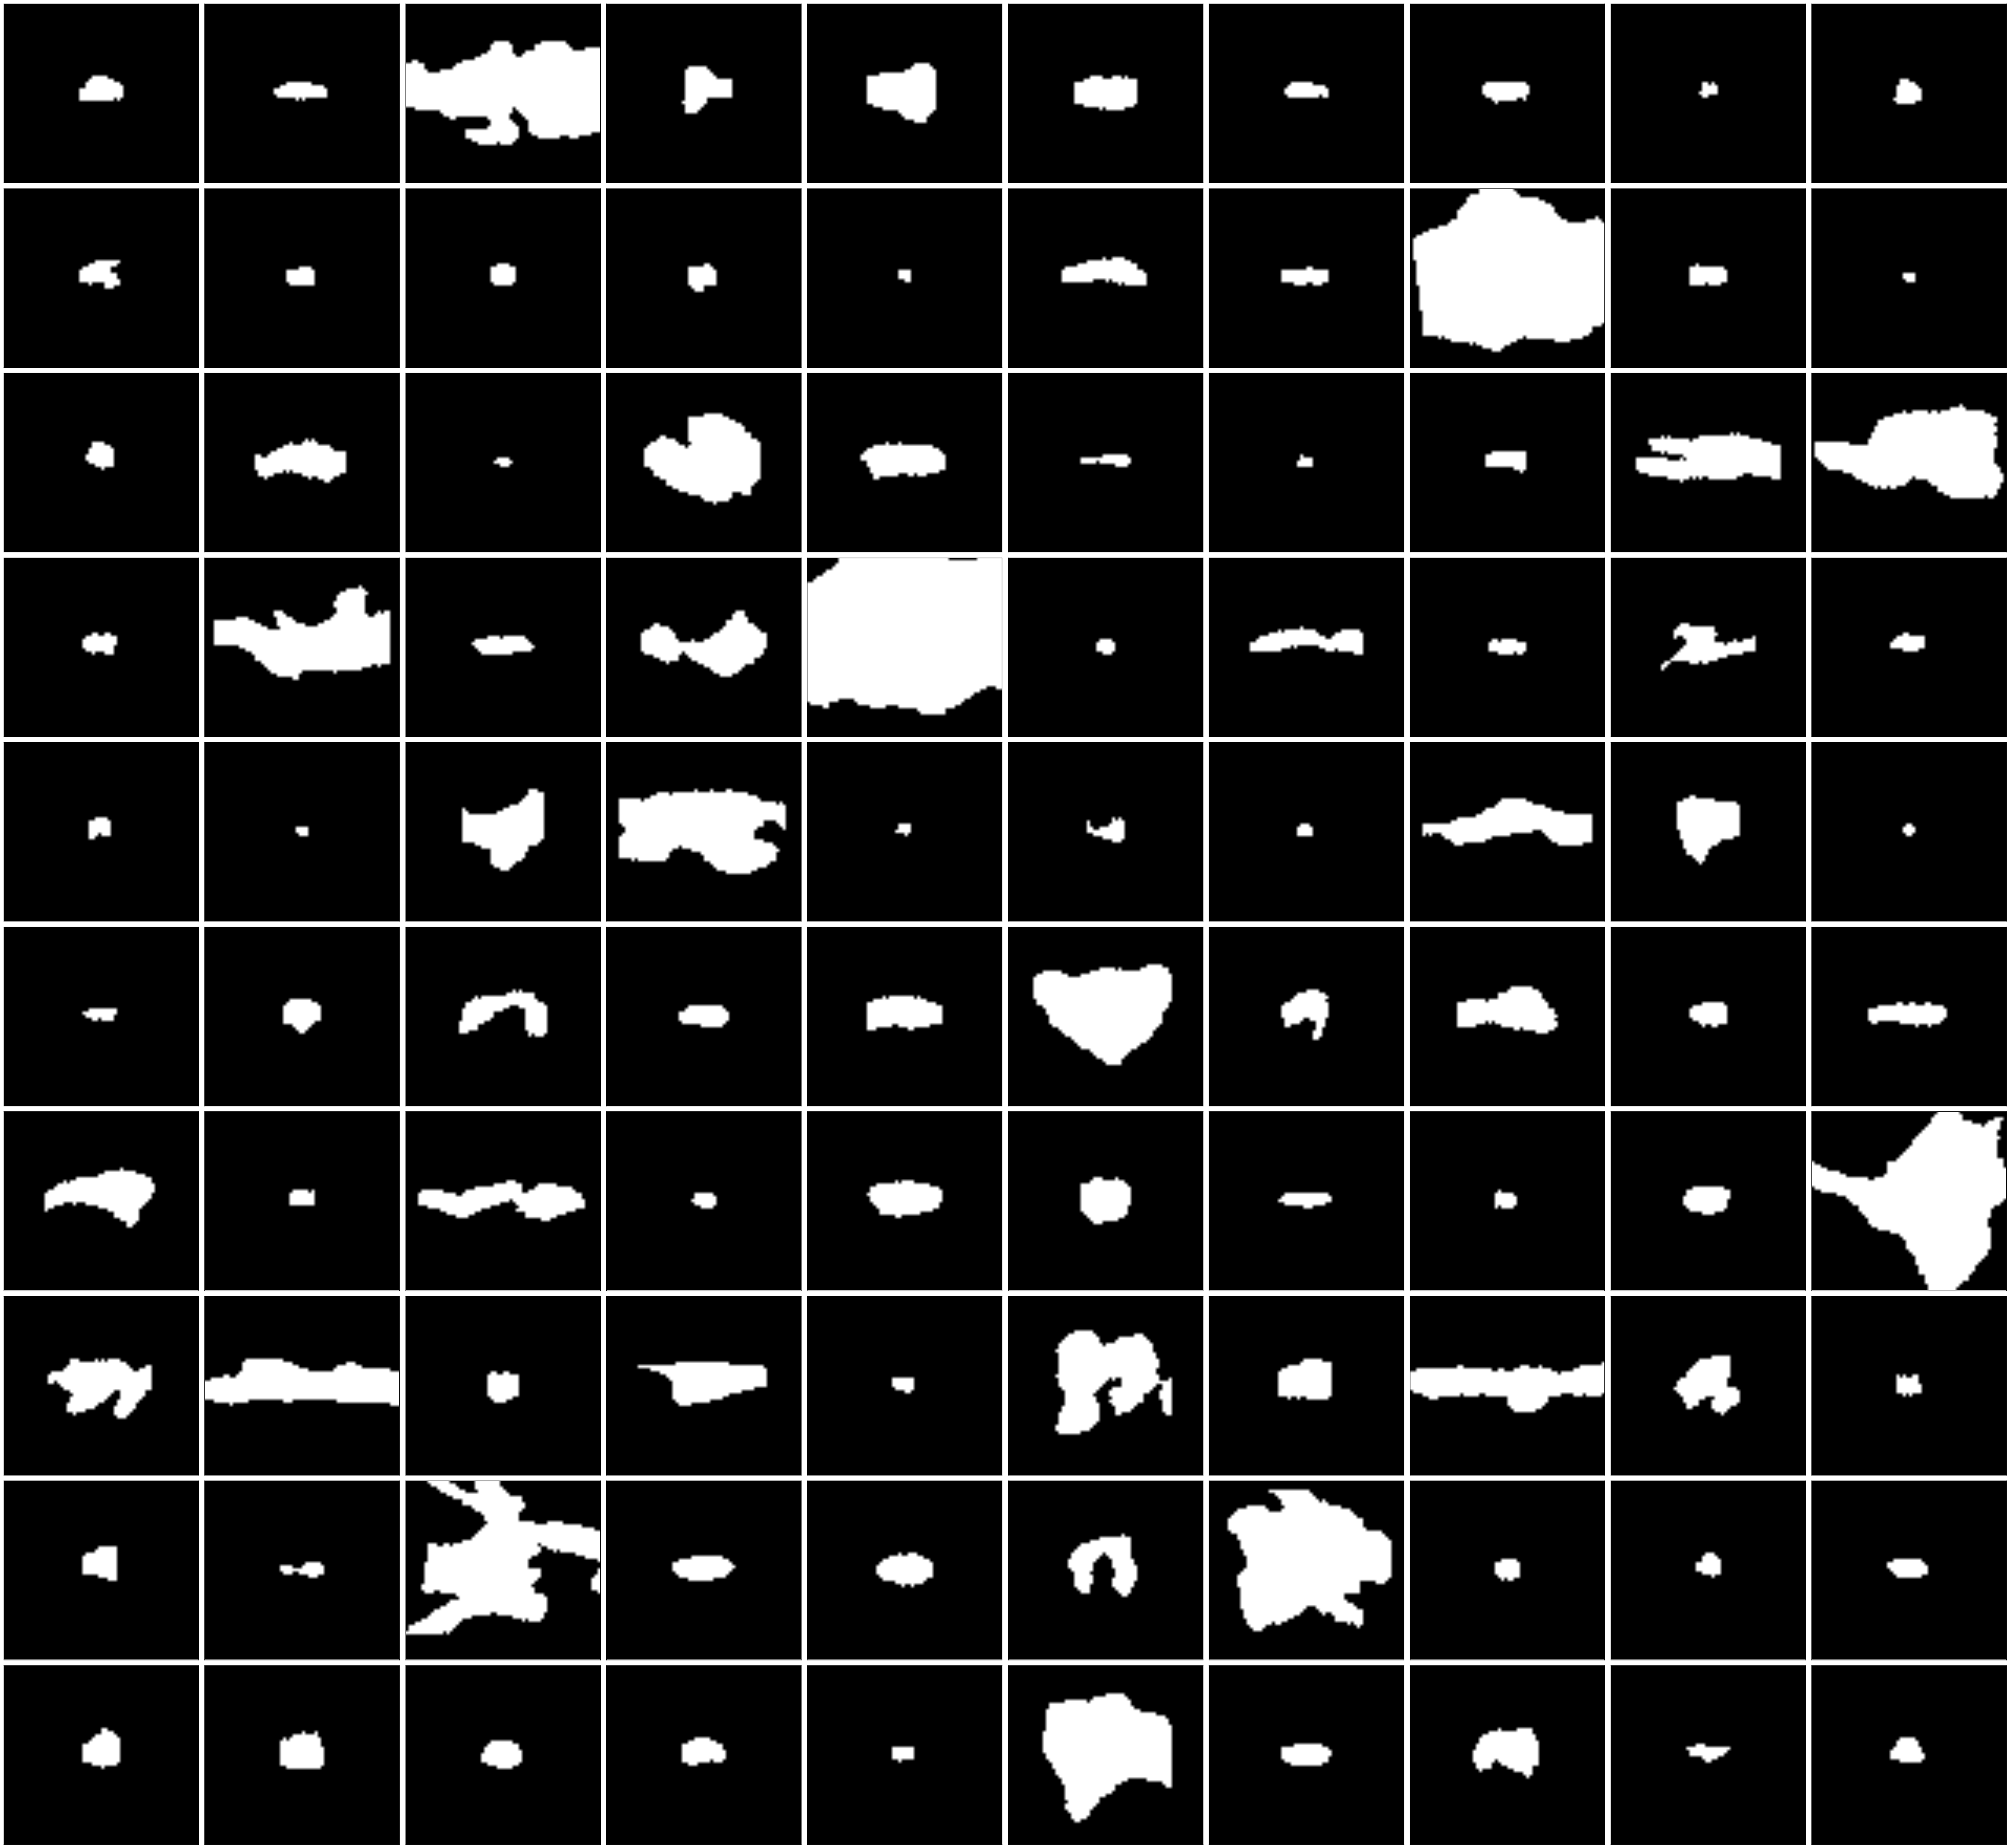

In [4]:
display_images_in_grids(cells_aligned_mirrored_padded[:100], nc=10)